In [49]:
library(Seurat)
library(SeuratDisk)
library(dplyr)
library(cowplot)
library(ggplot2)
library(ggpubr)
library(stringr)
library(tidyr)
library(ComplexHeatmap)

library(SCENIC)
library(AUCell)
library(loomR)

In [3]:
setwd("/home/lhc/script/ARDS/neutrophilic_asthma/metadata")

In [4]:
load('saved_Rdata/labeled_ding_harmony_combined_final_0314.Rdata')
load('saved_Rdata/labeled_neutrophil_harmony_combined_final_0314.Rdata')

# SCENIC

## Prepare files for pySCENIC

In [ ]:
ding_merged_loom <- as.loom(labeled_neutrophil_merged_data, assay = 'RNA', 
                            filename = "ding_neutrophil_merged_1201.loom",
                           max.size='20gb',overwrite = TRUE)
ding_merged_loom$close_all()

## Run pySCENIC

## Precess pySCENIC output

In [5]:
regulonAUC <- importAUCfromText('auc_mtx_ding_neutrophil_1201.csv')
regulonAUC <- regulonAUC[onlyNonDuplicatedExtended(rownames(regulonAUC)),]

In [6]:
tmp_meta_data <- labeled_neutrophil_merged_data@meta.data
regulonActivity_byCellType <- sapply(split(rownames(tmp_meta_data), tmp_meta_data$cell_type),
                                   function(cells) rowMeans(getAUC(regulonAUC)[,cells]))
regulonActivity_byCellType_Scaled <- scale(t(regulonActivity_byCellType), center = T, scale=T)

In [8]:
regulonAUC_data <- labeled_neutrophil_merged_data
regulonAUC_data@assays$RNA@data <- as(as.matrix(regulonAUC@assays@data$AUC), 'dgCMatrix')

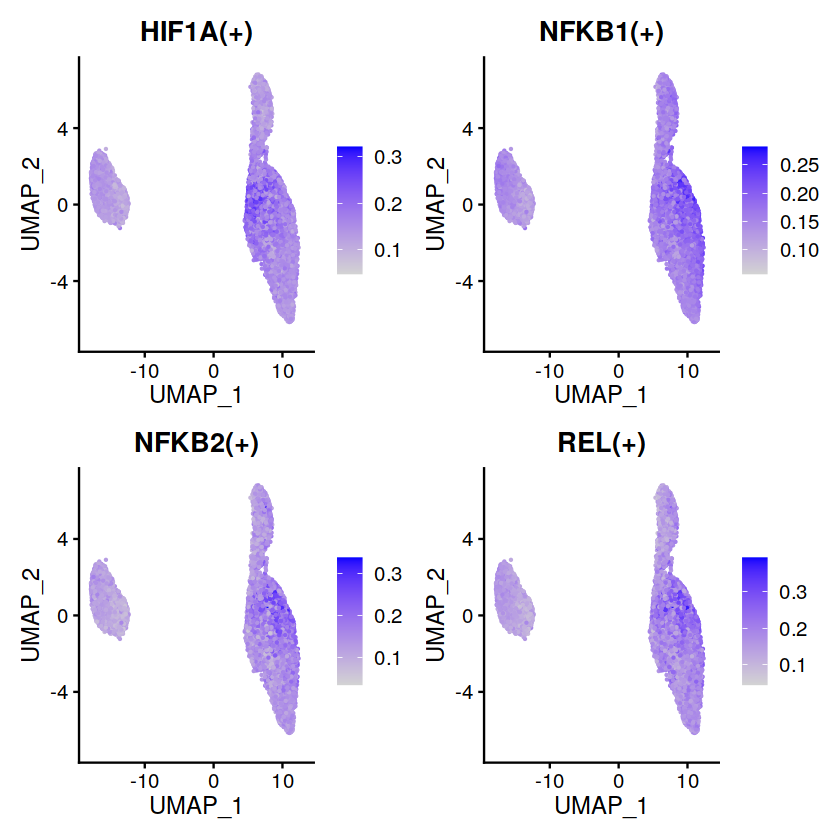

In [9]:
FeaturePlot(regulonAUC_data, c('HIF1A(+)', 'NFKB1(+)', 'NFKB2(+)', 'REL(+)'))

Warning message:
“`breaks` does not have the same length as `color`. The colors are
interpolated from the minimal to the maximal of `breaks`.”


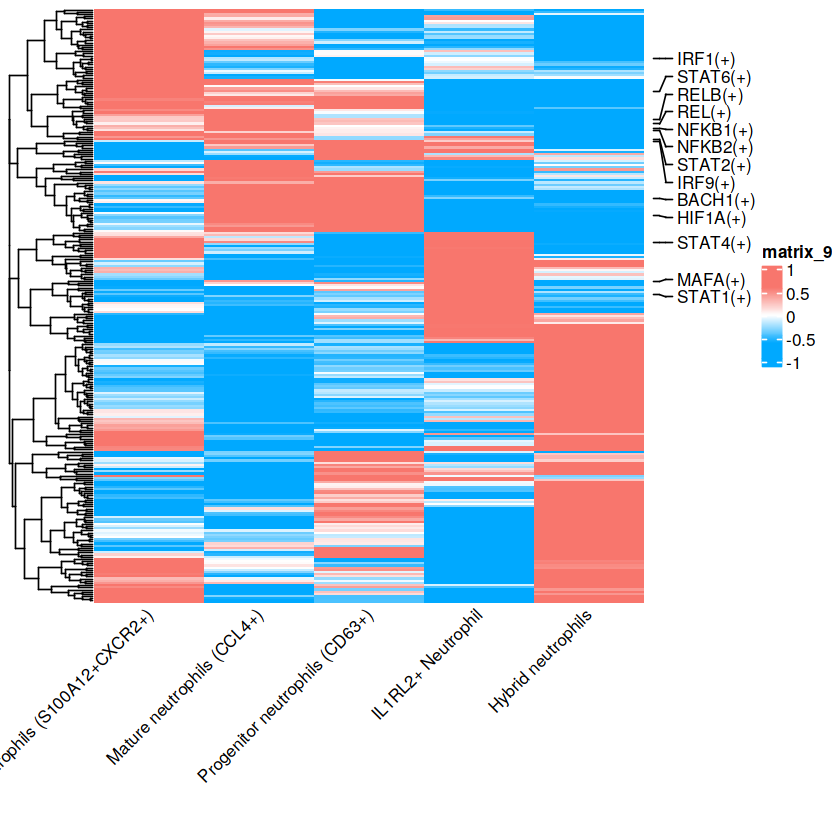

In [36]:
cell_type_order <- c('Mature neutrophils (S100A12+CXCR2+)', 'Mature neutrophils (CCL4+)', 'Progenitor neutrophils (CD63+)',
                     'IL1RL2+ Neutrophil', 'Hybrid neutrophils')
bk <- c(seq(-0.6,-0.01,by=0.01),seq(0,0.6,by=0.01))
A <- pheatmap(t(regulonActivity_byCellType_Scaled)[,cell_type_order],
             scale = "none",
             cluster_cols = FALSE,
             color = c(colorRampPalette(colors = c("#00a9ff","white"))(length(bk)/2),
                       colorRampPalette(colors = c("white","#F8766D"))(length(bk)/2)),
             #legend_breaks=seq(-8,8,2),
             show_rownames = F,
             breaks=bk,
             angle_col = '45',)

#genes <- c('IRF5(+)','IRF4(+)','ETV2(+)','TBP(+)','GATA6(+)','HLF(+)')
genes <- c('HIF1A(+)', 'NFKB1(+)', 'NFKB2(+)', 'REL(+)', 'RELB(+)','MAFA(+)','BACH1(+)',
          'IRF1(+)','IRF9(+)','STAT1(+)','STAT2(+)','STAT4(+)','STAT6(+)')
genes <- as.data.frame(genes)
gene_index <- genes$genes %>% lapply(function(x) which(row.names(t(regulonActivity_byCellType_Scaled))==x)) %>% unlist
A + rowAnnotation(link = anno_mark(at = gene_index, labels = genes$genes, labels_gp = gpar(fontsize = 10)))

In [128]:
genes <- c('HIF1A(+)', 'NFKB1(+)', 'NFKB2(+)', 'REL(+)', 'STAT2(+)','STAT6(+)')

tmp_TF_df <- data.frame(as.matrix(regulonAUC@assays@data$AUC)[genes,])
tmp_TF_df['gene'] <- row.names(tmp_TF_df)
tmp_TF_df <- tmp_TF_df %>% pivot_longer(-gene, names_to = "cellid", values_to = "expr") %>% data.frame
tmp_TF_df$cellid <- tmp_TF_df$cellid %>% gsub("\\.", "-", .)

cellname <- colnames(labeled_neutrophil_merged_data)
pos_cellname <- cellname[which(labeled_neutrophil_merged_data@meta.data$on_interest==1)]
neg_cellname <- cellname[which(labeled_neutrophil_merged_data@meta.data$on_interest==0)]

tmp_TF_df[(tmp_TF_df$cellid %in% neg_cellname),'cell_type'] <- 'pNeus'
tmp_TF_df[(tmp_TF_df$cellid %in% pos_cellname),'cell_type'] <- 'rs-Neus'

write.csv(tmp_TF_df, file='../metadata/tmp_TF_df.csv')

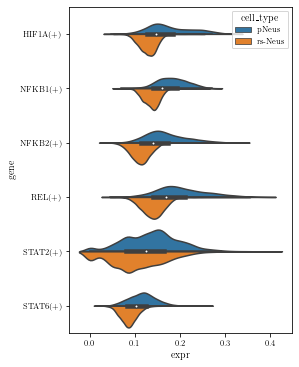

In [34]:
# Run in Python

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,6))
sns.violinplot(data=df, x="expr", y="gene", hue="cell_type", split=True)
plt.show()